The first part of the analysis is to find the main predictor for each country

In [1]:
from utils import *
import numpy as np
import statsmodels.api as sm

beers_ba, breweries_ba, users_ba, ratings_ba = load_data("ba")


In [6]:
users_ba.sample(10)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
123709,1,0,moyer_beer_lover.899911,Moyer_beer_lover,1.417172e+09,"United States, Pennsylvania"
1012,1036,142,timmy2b.118653,timmy2b,1.169636e+09,"United States, New York"
104447,2,0,rvthomas.908202,rvthomas,1.418555e+09,"United States, New York"
77514,1,0,slups.894445,slups,1.416222e+09,"United States, Texas"
49881,3,2,gilli24.333269,gilli24,1.243159e+09,"United States, Illinois"
15765,62,60,kack1533.1091685,KACK1533,1.452078e+09,"United States, Massachusetts"
62754,38,1,eotlbrewer.642655,EOTLBrewer,1.324206e+09,"United States, Illinois"
310,94,1,louislouis91.1075657,louislouis91,1.448968e+09,Ireland
89161,4,0,tbone_beerhorse.888158,TBone_BeerHorse,1.415185e+09,"United States, Washington"
94862,1,0,bikenick.6520,BikeNick,1.085652e+09,"United States, New Jersey"


In [2]:
columns_of_interest = ["appearance",  "aroma",  "palate",  "taste",  "overall"]
ratings_ba.dropna(subset=columns_of_interest + ["rating"], inplace=True)
X = ratings_ba[columns_of_interest]  # Predictors
y = ratings_ba["rating"]             # Target variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.728e+10
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:40:52   Log-Likelihood:             2.2519e+07
No. Observations:             4769675   AIC:                        -4.504e+07
Df Residuals:                 4769669   BIC:                        -4.504e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.489e-05   7.48e-06      7.334      0.0

C:\Users\Mathi\AppData\Local\Temp\ipykernel_29460\3950099688.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


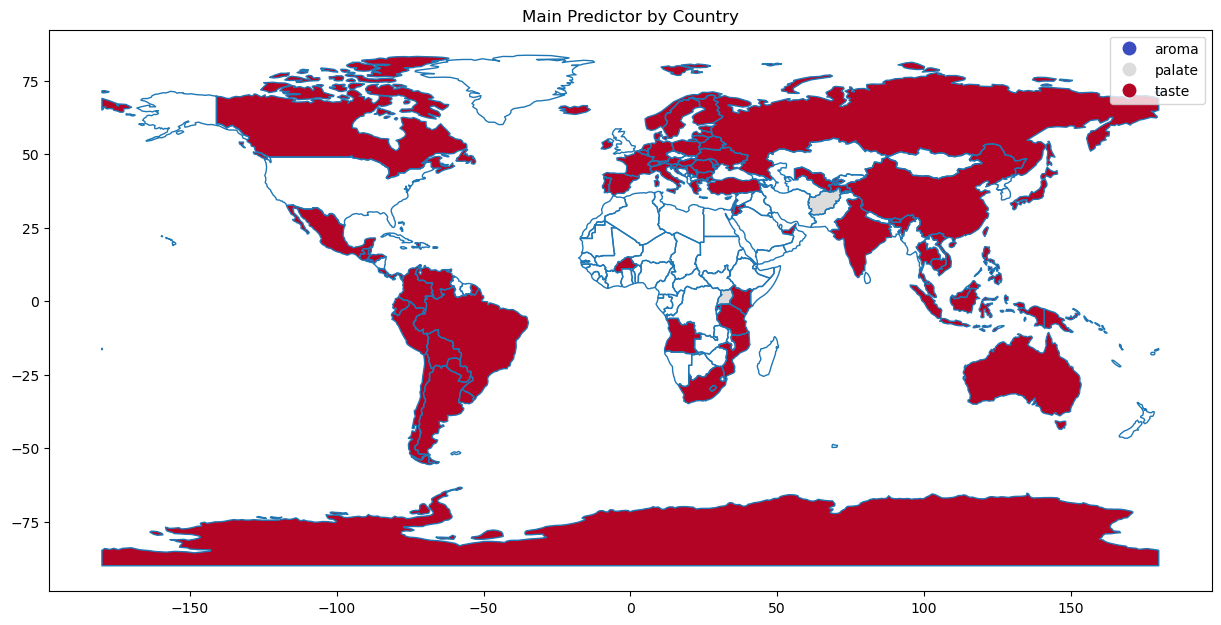

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process = (data_to_process - data_to_process.mean()) / data_to_process.std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

# Merge the datasets using the "user_id" column
merged_data = pd.merge(ratings_ba, users_ba[['user_id', 'location']], on='user_id', how='inner')

# Create an empty DataFrame to store regression results
results = pd.DataFrame(columns=['country', 'main_predictor'])

# Define the columns of interest (predictors)
columns_of_interest = ["appearance", "aroma", "palate", "taste", "overall"]

# Loop through each country and perform linear regression
for country in merged_data['location'].unique():
    country_data = merged_data[merged_data['location'] == country]
    try:
        res=get_LR(country_data, columns_of_interest)
        main_predictor = res.params.idxmax()  # Get the main predictor with the highest coefficient
        results = pd.concat([results, pd.DataFrame({'country': [country], 'main_predictor': [main_predictor]})], ignore_index=True)
    except:
        pass



# Load a world shapefile for mapping (you may need to download a suitable shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with the results DataFrame
world = world.merge(results, left_on='name', right_on='country', how='left')

# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='main_predictor', cmap='coolwarm', ax=ax, legend=True)
plt.title('Main Predictor by Country')
plt.show()
